# Introduction

We were arguing one day over what is a good tournament style for volleyball, where we are rotating players through different teams, while ensuring that it was fair for everyone. Here's a notebook to generate a pretty good (but not necessarily optimal) set of _k_ games of doubles volleyball given _n_ players in attendance such that:

1. Each player plays the same number of times.
2. Each pair of players appears on the same team the same number of times. 
3. No two teams play each other more than once. 

# Imports

In [2]:
import itertools as it
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math

# Definitions

In [3]:
n = 6 # number of players in attendance  
k = 12 # number of games  
s = 100000 # number of simulations, see below

# Theory

There are 

$$ t =\ _n C_2 $$ 

possible teams. 

Players are numbered 1 through $ n $. 

The number of games with $ t $ teams is naively $ _t C_2 $. However this includes many teams with players playing themselves, which are obviously impossible. To account for this, we determine that there are $ m = $ $ n-2 $ _other_ players for each team to play, and therefore 

$$ t_o =\ _m C_2 $$ 

other possible teams to play for each team.

The number of _possible_ games is then 

$$ \frac{ t \ \ \times \ \ t_o}{2} $$ 

where the division by 2 is to remove teams where the same teams play twice.

# Simulate

In [4]:
possible_teams = list(it.combinations(range(1,n + 1), 2))

Here are all the combinations of teams, but they include some "impossible" games because a player can't play against themself. 

In [5]:
impossible_games = list(it.combinations(possible_teams, 2))

To eliminate those impossible games, remove games where the same player plays both games.

In [6]:
possible_games_bool = [not any([i in game[0] for i in game[1]]) for game in impossible_games]
possible_games = [impossible_games[i] for i in range(len(impossible_games)) if possible_games_bool[i] == True]

In [7]:
len(possible_games)

45

This checks out with the theory:

In [8]:
print((len(list(it.combinations(range(n), 2))) * len(list(it.combinations(range(n - 2), 2))))/2)

45.0


# Practical Solution

Unfortunately, even with just 6 players, 45 games is too many to play in a single day and with only one volleyball net. If you only have one net available, you may want to reduce the total number of games. Therefore, you can use the following brute force algorithm to find a set of $ k $ games from the possible games that have a relatively low variance in the number of games played per player and the number of times each pair of players play with each other.

This solution simulates $ s $ sets of $ k $ games and calculates a score which is the sum of the standard deviation of the number of games player per player and the standard deviations of the number of times each team plays (i.e. the number of times each pair of players play together). We choose not to cycle through all possible sets because the sample space is likely too large:

In [9]:
g = len(possible_games)
r = k
math.factorial(g)/((math.factorial(r)*math.factorial(g - r)))

28760021745.0

Initialize lists:

In [10]:
games_sets_list = list()
player_games_counts_list = list()
team_games_counts_list = list()

# std_devs_player_list = list()
# std_devs_teams_list = list()
scores_list = list()

Run the simulations:

In [11]:
for _ in tqdm(range(s)):
    game_set = np.random.choice(range(len(possible_games)), size=k, replace=False)
    game_set = [possible_games[i] for i in game_set]
    
    games_array = np.array(game_set)
    teams = games_array.reshape(games_array.shape[0]*2,2)
    team_games = np.empty(len(teams), dtype=object)
    team_games[:] = list(map(tuple, teams))


    player_games_counts = np.unique(np.ravel(game_set), return_counts=True)
    team_games_counts = np.unique(np.ravel(team_games), return_counts=True)
    
    games_sets_list.append(game_set)
    player_games_counts_list.append(player_games_counts)
    team_games_counts_list.append(team_games_counts)
    
    std_dev_player = np.std(player_games_counts[1])
    std_dev_team = np.std(team_games_counts[1])
    
#     std_devs_player_list.append(std_dev_player)
#     std_devs_team_list.append(np.std(std_dev_team))
    scores_list.append(std_dev_player + std_dev_team)

Visualize the distribution of scores:

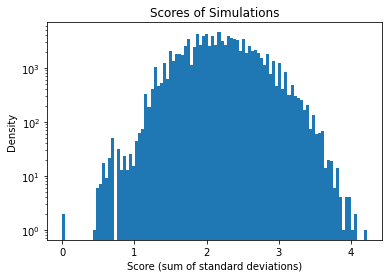

In [14]:
plt.hist(scores_list, bins=100);
plt.title('Scores of Simulations')
plt.xlabel('Score (sum of standard deviations)')
plt.ylabel('Density');
plt.yscale('log')

Print the results in order from best to worst. To stop, use _Kernel > Interrupt Kernel_ from the main menu.

In [ ]:
idx_ordered = np.argsort(scores_list)
for i, idx in enumerate(idx_ordered):
    print('SET #%d, SCORE = %s' % (i, str(scores_list[idx])))
    games_set = games_sets_list[idx]
    print('GAMES (%d):' % len(games_set))
    for game in games_set:
        print(' & '.join([str(i) for i in game[0]]) + ' vs. ' + ' & '.join([str(i) for i in game[1]]))
    print('')
    print('PlAYER GAMES COUNTS:')
    for player, counts in zip(player_games_counts_list[idx][0], player_games_counts_list[idx][1]):
        print('Player %d plays %d game(s).' % (player, counts))
    print('')
    print('TEAM GAMES COUNTS:')
    for team, counts in zip(team_games_counts_list[idx][0], team_games_counts_list[idx][1]):
        print('Team %s plays %d game(s).' % (str(team), counts))
    print('')
    print('')
    input('Create a new set? (Click any button)')
    print('')
    print('')

In [15]:
chosen_game = games_sets_list[idx_ordered[0]]

In [16]:
chosen_game

[((1, 2), (4, 6)),
 ((1, 6), (2, 4)),
 ((1, 3), (4, 5)),
 ((2, 4), (5, 6)),
 ((1, 4), (3, 5)),
 ((2, 3), (4, 6)),
 ((1, 4), (2, 3)),
 ((1, 3), (2, 5)),
 ((2, 5), (3, 6)),
 ((1, 2), (5, 6)),
 ((3, 6), (4, 5)),
 ((1, 6), (3, 5))]

# Ordering

Another thing we may want to consider is the order in which the games are reported. Tayar? Das all u bro.

Sample space:

In [17]:
math.factorial(k)

479001600

# Disclaimer 

While this algorithm produces good results, it does not necessarily produce an optimal result. We can run it on a while loop until `score = 0`, but I don't know how to guarentee there is an optimal solution given $ n $ players and $ k $ games, so you might be running endlessly. I will say anecdotally that with 6 players and 12 games, I was able to find a set of games that was perfect, even though running this code last weekend several times I did not find it. In any case, should be good enough for beach volleyball anyway! 

`SET #0, SCORE = 0.0`\
`GAMES (12):`\
`1 & 2 vs. 4 & 6`\
`1 & 6 vs. 2 & 4`\
`1 & 3 vs. 4 & 5`\
`2 & 4 vs. 5 & 6`\
`1 & 4 vs. 3 & 5`\
`2 & 3 vs. 4 & 6`\
`1 & 4 vs. 2 & 3`\
`1 & 3 vs. 2 & 5`\
`2 & 5 vs. 3 & 6`\
`1 & 2 vs. 5 & 6`\
`3 & 6 vs. 4 & 5`\
`1 & 6 vs. 3 & 5`\
`PlAYER GAMES COUNTS:`\
`Player 1 plays 8 game(s).`\
`Player 2 plays 8 game(s).`\
`Player 3 plays 8 game(s).`\
`Player 4 plays 8 game(s).`\
`Player 5 plays 8 game(s).`\
`Player 6 plays 8 game(s).`\
`TEAM GAMES COUNTS:`\
`Team (1, 2) plays 2 game(s).`\
`Team (1, 3) plays 2 game(s).`\
`Team (1, 4) plays 2 game(s).`\
`Team (1, 6) plays 2 game(s).`\
`Team (2, 3) plays 2 game(s).`\
`Team (2, 4) plays 2 game(s).`\
`Team (2, 5) plays 2 game(s).`\
`Team (3, 5) plays 2 game(s).`\
`Team (3, 6) plays 2 game(s).`\
`Team (4, 5) plays 2 game(s).`\
`Team (4, 6) plays 2 game(s).`\
`Team (5, 6) plays 2 game(s).`